In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bu Python Code Yunus Karagün Tarafından Yazılmıştır. Tüm Hakları Saklıdır. (V2.Stable (01.09.2021))

dosya=47 #kasa dosyası
gun=31 #aydaki gün sayısı Yazılacak
ay="08" #hangi ay olduğu
yil="2021"
loc = ("D:\\Python\\" + ay + "\\") #dosyaların bulunduğu adres
N_Gunu = str(gun).zfill(2)+"."+ ay + "."+ yil #"08.09.2021" #Raporda Çıkması istenen Tarih


magaza_kasa = pd.read_excel("Adresler.xlsx",  index_col=0)

kodlar = pd.read_excel("Anahtar.xlsx",  sheet_name= "KF", index_col=None) #Kasa Kodları

hucre = magaza_kasa["Adres"]

sayfalar = []  #excel dosyasındaki tarih olan sayfa adlarından oluşan bir liste yapıyoruz.
for gn in range (1, gun+1):
    sayfalar.append((str(gn).zfill(2)+"."+ ay + "."+ yil))
    
for dsy in range (1, dosya+1):
    ciro = pd.read_excel(loc + str(dsy).zfill(3) + ".xlsx",
                      sheet_name=sayfalar,
                      skiprows = 2, nrows = 65, header = None, index_col=None, usecols=[0, 1, 2, 3, 4, 5, 6, 7])

    for g in range (0, gun):
        gunluk_kasa = []
        gunluk_kasa.append(list(ciro.keys())[g])
        for i in range (1, 67):
            aa=ciro[list(ciro.keys())[g]].iloc[eval(hucre[i])]
            gunluk_kasa.append(aa)  
        magaza_kasa[str(dsy).zfill(2) + "-" + str(g+1).zfill(2)] = gunluk_kasa     

magaza_kasa_T = magaza_kasa.T
magaza_kasa_T['MAĞAZA ADI'] = magaza_kasa_T['MAĞAZA ADI'].str.strip()
magaza_kasa_T = magaza_kasa_T.merge(kodlar,
                                      on ='MAĞAZA ADI', how="left").set_axis(magaza_kasa_T.index)


# Yatırlan Nakitler Bölümü

sayfalar = [] 
for i in range (1, gun+1):
    sayfalar.append((str(i).zfill(2)+"."+ ay + "."+ yil))
df2 = pd.DataFrame()
for i in range (1, dosya+1):
    sheets = pd.read_excel(loc + str(i).zfill(3) + ".xlsx",
                      sheet_name=sayfalar,
                      skiprows = 57, nrows = 5, header = 1, index_col=0, usecols=[0, 1, 2, 3, 4, 5, 6])
    
    magaza = pd.read_excel(loc + str(i).zfill(3) + ".xlsx",
                           sheet_name="01." + ay + "."+ yil,
                           skiprows = 2, nrows = 1, header = None, usecols=[5])
    
    dfs = []
    for framename in sheets.keys():
        temp_df = sheets[framename]
        temp_df['Sayfa'] = framename
        dfs.append(temp_df)
    df = pd.concat(dfs)
    df.loc[:,"Dosya Adı"] = str(i).zfill(3) + ".xlsx"
    df.loc[:,"Magaza"] = magaza.at[0, 5]
    
 
    df1 = df.dropna(thresh=4)
    df2 = pd.concat([df2, df1])

df2['Magaza'] = df2['Magaza'].str.strip()

In [3]:
#Genel fark 1 TL'den büyük ve küçük olanlar

g_fark = magaza_kasa_T[["MAĞAZA ADI", "DS-Tarih", "GENEL FARK"]]
g_fark.drop("Adres", inplace=True)
g_fark[(g_fark["GENEL FARK"] < -1) | (g_fark["GENEL FARK"] > 1)]
Nakitler = magaza_kasa_T[["KASA KODU", "MAĞAZA ADI", "DS-Tarih", "FATURALI SATIŞLAR", "GİDER PUSULASI", "CİRO TOPLAMI", "NAKİT_1", "EURO TUTAR", "USD TUTAR", "MASRAF", "NAKİT", "YATIRILAN TL FARK", "YATIRILAN EURO FARK","YATIRILAN USD FARK", "İL"]]
Nakitler.drop("Adres", inplace=True)

Bugun_n = Nakitler[Nakitler["DS-Tarih"] == N_Gunu]
with pd.ExcelWriter(N_Gunu+'-x-Rapor.xlsx') as writer:
    magaza_kasa_T.to_excel(writer, sheet_name = 'Raw')   
    Nakitler.to_excel(writer, sheet_name = 'Main')
    Bugun_n.to_excel(writer, sheet_name = N_Gunu)
    g_fark[(g_fark["GENEL FARK"] < -1) | (g_fark["GENEL FARK"] > 1)].to_excel(writer, sheet_name = "Hatalı")
    magaza_kasa_T[["MAĞAZA ADI", "DS-Tarih", "NOTLAR"]].dropna().to_excel(writer, sheet_name = "Notlar")
    df2[(df2[["YATIRILAN TL", "YATIRILAN USD", "YATIRILAN EURO"]].sum(axis=1, skipna=True) != 0)].to_excel(writer, sheet_name = "Yatırılan Nakitler")

In [4]:
g_fark[(g_fark["GENEL FARK"] < -1) | (g_fark["GENEL FARK"] > 1)]

,MAĞAZA ADI,DS-Tarih,GENEL FARK


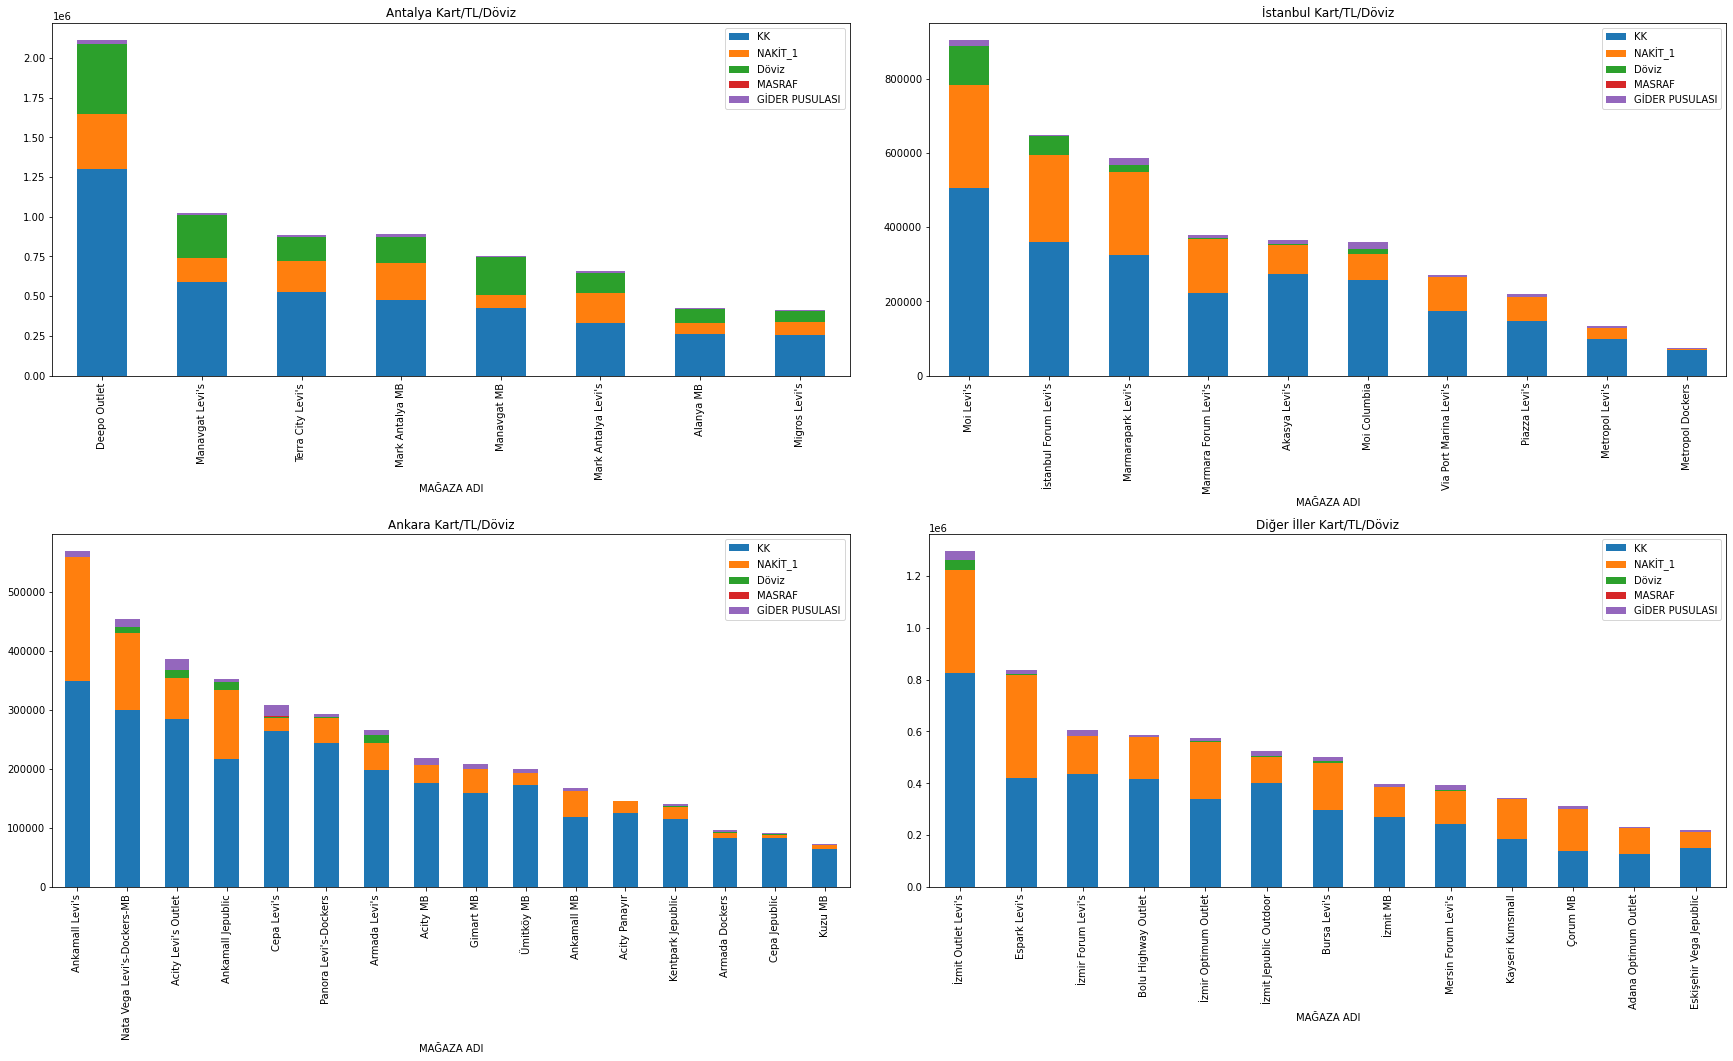

In [6]:
Nakit_Satis = Nakitler.groupby(["MAĞAZA ADI", "İL"]).agg({"CİRO TOPLAMI":"sum","NAKİT":"sum", "NAKİT_1":"sum", "MASRAF":"sum","GİDER PUSULASI":"sum"}).sort_values("CİRO TOPLAMI", ascending=False)
Nakit_Satis["KK"] = Nakit_Satis["CİRO TOPLAMI"]-Nakit_Satis["NAKİT"]
Nakit_Satis["Döviz"] = (Nakit_Satis["NAKİT"]- Nakit_Satis["NAKİT_1"] - Nakit_Satis["MASRAF"]).round(decimals = 2)

Grafik = Nakit_Satis.reset_index(level="İL")
Antalya=Grafik[Grafik["İL"] == "Antalya"]
Istanbul=Grafik[Grafik["İL"] == "İstanbul"]
Ankara=Grafik[Grafik["İL"] == "Ankara"]
Diger=Grafik[(Grafik["İL"] != "Antalya") & (Grafik["İL"] != "Ankara") & (Grafik["İL"] != "İstanbul")]



# Antalya[["GİDER PUSULASI", "KK", "NAKİT_1", "Döviz", "MASRAF"]].plot(kind="bar", figsize=(10, 6),  stacked=True, title='Antalya Kart/TL/Döviz', ylabel='TUTAR')
# Istanbul[["GİDER PUSULASI", "KK", "NAKİT_1", "Döviz", "MASRAF"]].plot(kind="bar", figsize=(10, 6),  stacked=True, title='İstanbul Kart/TL/Döviz', ylabel='TUTAR')
# Ankara[["GİDER PUSULASI", "KK", "NAKİT_1", "Döviz", "MASRAF"]].plot(kind="bar", figsize=(10, 6),  stacked=True, title='Ankara Kart/TL/Döviz', ylabel='TUTAR')
# Diger[["GİDER PUSULASI", "KK", "NAKİT_1", "Döviz", "MASRAF"]].plot(kind="bar", figsize=(10, 6),  stacked=True, title='Diğer İller Kart/TL/Döviz', ylabel='TUTAR')



figure, axes = plt.subplots(2, 2)

Antalya[["KK", "NAKİT_1", "Döviz", "MASRAF", "GİDER PUSULASI"]].plot(ax=axes[0, 0], kind="bar", figsize=(30, 15), stacked=True, title='Antalya Kart/TL/Döviz')
Istanbul[["KK", "NAKİT_1", "Döviz", "MASRAF", "GİDER PUSULASI"]].plot(ax=axes[0, 1], kind="bar", figsize=(30, 15), stacked=True, title='İstanbul Kart/TL/Döviz')
Ankara[["KK", "NAKİT_1", "Döviz", "MASRAF", "GİDER PUSULASI"]].plot(ax=axes[1, 0], kind="bar", figsize=(30, 15), stacked=True, title='Ankara Kart/TL/Döviz')
Diger[["KK", "NAKİT_1", "Döviz", "MASRAF", "GİDER PUSULASI"]].plot(ax=axes[1, 1], kind="bar", figsize=(30,15), stacked=True, title='Diğer İller Kart/TL/Döviz')

figure.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.45)

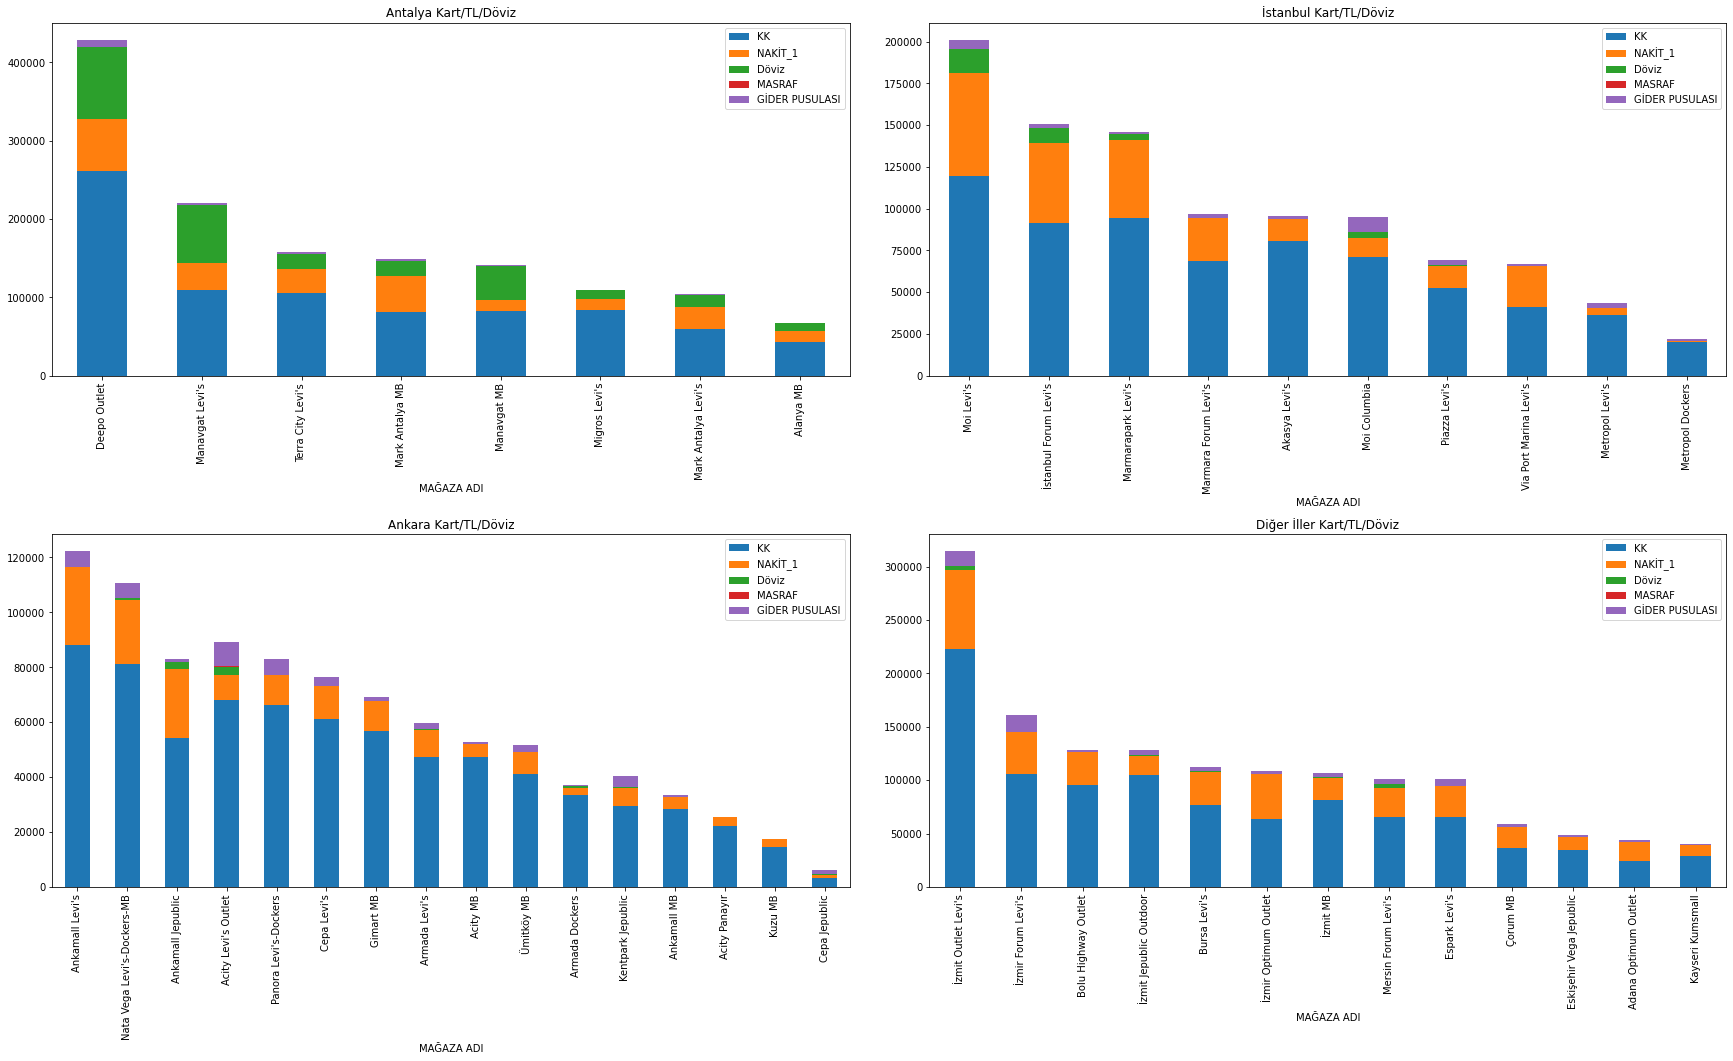

In [9]:
figure.savefig('202108_Nakit_doviz.pdf')

In [31]:
from matplotlib.backends.backend_pdf import PdfPages

In [20]:
figure.savefig('Nakit_doviz.pdf',
                bbox_inches="tight")

In [181]:
Grafik[Grafik["İL"] == "Antalya"]

,İL,CİRO TOPLAMI,NAKİT,NAKİT_1,MASRAF,KK,Döviz
MAĞAZA ADI,,,,,,,
Deepo Outlet,Antalya,370534.53,137821.30,56229.20,0.0,232713.23,81592.10
Manavgat Levi's,Antalya,187087.84,90242.88,26913.88,0.0,96844.96,63329.00
Terra City Levi's,Antalya,135384.57,40665.73,24825.98,0.0,94718.84,15839.75
Manavgat MB,Antalya,132168.75,54422.23,11886.03,0.0,77746.52,42536.20
Mark Antalya MB,Antalya,124397.69,58283.22,39490.22,0.0,66114.47,18793.00
Migros Levi's,Antalya,93176.12,19384.51,12744.51,0.0,73791.61,6640.00
Mark Antalya Levi's,Antalya,89788.76,39085.16,26512.16,0.0,50703.60,12573.00
Alanya MB,Antalya,57121.03,22114.11,12944.81,130.0,35006.92,9039.30


In [7]:
Nakit_Satis["GİDER PUSULASI-Yüzde"] = Nakit_Satis["GİDER PUSULASI"]/Nakit_Satis["CİRO TOPLAMI"]*100

In [8]:
Nakit_Satis.sort_values("GİDER PUSULASI-Yüzde", ascending=False)

,,CİRO TOPLAMI,NAKİT,NAKİT_1,MASRAF,GİDER PUSULASI,KK,Döviz,GİDER PUSULASI-Yüzde
MAĞAZA ADI,İL,,,,,,,,
Cepa Levi's,Ankara,289137.86,24721.95,22351.20,180.00,18956.22,264415.91,2190.75,6.556118
Acity MB,Ankara,206880.46,30639.91,30324.92,0.00,12174.50,176240.55,314.99,5.884799
Mersin Forum Levi's,Mersin,374824.75,132471.39,129366.39,0.00,20059.43,242353.36,3105.00,5.351682
Acity Levi's Outlet,Ankara,368391.40,82843.23,68124.51,0.00,18998.70,285548.17,14718.72,5.157205
Moi Columbia,İstanbul,342309.05,86090.11,70349.36,0.00,16536.03,256218.94,15740.75,4.830731
Metropol Levi's,İstanbul,129004.36,30072.93,29278.05,0.00,5713.15,98931.43,794.88,4.428649
Çorum MB,Çorum,300373.24,161657.67,161517.68,0.00,13271.89,138715.57,139.99,4.418466
Piazza Levi's,İstanbul,211697.54,63517.38,63517.38,0.00,9073.98,148180.16,0.00,4.286294
Armada Dockers,Ankara,93123.92,10094.57,8507.62,75.00,3814.17,83029.35,1511.95,4.095801
